In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import umap.umap_ as umap

In [3]:
SEED = 1234

In [4]:
""" Define variables """
N_EPOCHS = 100
N_CLASSES = 10 
BATCH_SIZE = 64
LATENT_DIM = 50
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True 

In [6]:
from data_functions.dataloaders import load_MNIST
from data_functions.dataprocessors import label_to_onehot

In [7]:
(X_train, Y_train), (X_test, Y_test) = load_MNIST("data")

In [8]:
C_train = label_to_onehot(Y_train, N_CLASSES)
C_test = label_to_onehot(Y_test, N_CLASSES)

In [9]:
X_train = X_train.reshape((X_train.shape[0], 1, 28, 28))

In [10]:
X_test = X_test.reshape((X_test.shape[0], 1, 28, 28))

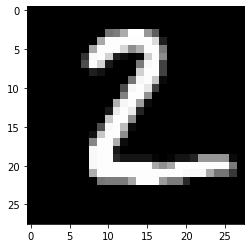

In [11]:
plt.imshow(X_test[1][0], cmap="gray")

In [12]:
class Encoder(nn.Module):
    def __init__(self, label_dim, latent_dim):
        super().__init__()
        # Implement CNN here 
        # 1 * 28 * 28 -> 16 * 12 * 12 -> 32 * 4 * 4
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2)
        self.linear = nn.Linear(4*4*32 + label_dim, 300)
        self.mu_z = nn.Linear(300, latent_dim)
        self.logvar_z = nn.Linear(300, latent_dim)
    
    def forward(self, x, c):
        # Implement CNN here
        out = F.relu(self.conv1(x)) # [N, 16, 12, 12]
        out = F.relu(self.conv2(out)) # [N, 32, 4, 4]
        out = out.reshape((out.shape[0], -1)) # [N, 4*4*32]
        out = F.relu(self.linear(torch.cat([out, c], axis=1))) # [N, 300]
        mu_out = self.mu_z(out) # [N, latent_dim]
        logvar_out = self.logvar_z(out) # [N, latent_dim]
        
        return mu_out, logvar_out

In [13]:
class Decoder(nn.Module): 
    def __init__(self, latent_dim, label_dim):
        super().__init__()
        # Implement CNN here 
        self.linear1 = nn.Linear(latent_dim + label_dim, 300)
        self.linear2 = nn.Linear(300,4*4*32)
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(1, 1, kernel_size=4)
    
    def forward(self, z, c):
        # Implement CNN here 
        out = F.relu(self.linear1(torch.cat([z, c], axis=1))) # [N, 300]
        out = F.relu(self.linear2(out)) # [N, 4*4*32]
        out = out.reshape((out.shape[0], 32, 4, 4)) # [N, 32, 4, 4]
        out = F.relu(self.conv1(out)) # [N, 16, 11, 11]
        out = F.relu(self.conv2(out)) # [N, 1, 25, 25]
        out = torch.sigmoid(self.conv3(out)) # [N, 1, 28, 28]
        return out

In [14]:
enc = Encoder(N_CLASSES, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, N_CLASSES).type(torch.float64)

In [15]:
train_dataset = TensorDataset(X_train, C_train)
test_dataset = TensorDataset(X_test, C_test)

train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [16]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

In [17]:
""" Loss function """
def loss_fn(recon_x, x, mu, log_var):
    recon_x = recon_x.reshape((recon_x.shape[0], -1))
    x = x.reshape((x.shape[0], -1))
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [18]:
def forward(x, c):
    mu, logvar = enc(x, c)

    eps = torch.randn(mu.shape)
    std = torch.exp(0.5*logvar)
    z = eps * std + mu
    x_gen = dec(z, c)
    
    return x_gen, mu, logvar

In [19]:
train_losses = []
test_losses = []

for ep in range(N_EPOCHS):
    for x, c in train_iter:
        # Zero grad
        optimizer.zero_grad()

        # Forward
#         mu, logvar = enc(x, c)

#         eps = torch.randn(mu.shape)
#         std = torch.exp(0.5*logvar)
#         z = eps * std + mu
#         x_gen = dec(z, c)
        x_gen, mu, logvar = forward(x, c)

        # Loss
        loss = loss_fn(x_gen, x, mu, logvar)

        # Backward 
        loss.backward()

        # Update
        optimizer.step()
    
    x_gen, mu, logvar = forward(X_train, C_train)
    loss = loss_fn(x_gen, X_train, mu, logvar)
    train_losses.append(loss.item())
    
    x_gen, mu, logvar = forward(X_test, C_test)
    loss = loss_fn(x_gen, X_test, mu, logvar)
    test_losses.append(loss.item())
    
    print("Epoch [%d / %d] train loss: %f test loss: %f" %(ep + 1, N_EPOCHS, train_losses[-1], test_losses[-1]))

Epoch [1 / 100] train loss: 24066249.231067 test loss: 4020043.739678
Epoch [2 / 100] train loss: 19784733.589252 test loss: 3314824.782363
Epoch [3 / 100] train loss: 18529456.779331 test loss: 3111146.826820
Epoch [4 / 100] train loss: 18263969.966849 test loss: 3070038.489986
Epoch [5 / 100] train loss: 18235241.769047 test loss: 3066530.540227
Epoch [6 / 100] train loss: 18234673.394924 test loss: 3066736.499176
Epoch [7 / 100] train loss: 18234808.710708 test loss: 3066811.569406
Epoch [8 / 100] train loss: 18234894.655678 test loss: 3066850.128297
Epoch [9 / 100] train loss: 18234950.291738 test loss: 3066873.271297
Epoch [10 / 100] train loss: 18234978.838931 test loss: 3066884.700103
Epoch [11 / 100] train loss: 18234991.486383 test loss: 3066889.683936
Epoch [12 / 100] train loss: 18234996.685066 test loss: 3066891.720037
Epoch [13 / 100] train loss: 18234998.749514 test loss: 3066892.526844
Epoch [14 / 100] train loss: 18234999.589389 test loss: 3066892.847753
Epoch [15 / 100

KeyboardInterrupt: 

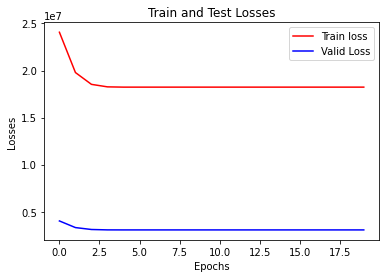

In [20]:
plt.plot(train_losses, "r")
plt.plot(test_losses, "b")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.title("Train and Test Losses")
plt.legend(["Train loss", "Valid Loss"])

In [21]:
## MSE Loss ##
prior = torch.distributions.Normal(0, 1)
z = prior.sample((X_test.shape[0], LATENT_DIM)).type(torch.float64)
X_out = dec(z.to(device), C_test.to(device))
X_out = X_out.detach()
print("MSE Loss between generated data and test data: {}".format(torch.nn.MSELoss()(X_out, X_test).item()))


MSE Loss between generated data and test data: 0.09640731114810468


In [22]:
## Plot generated images ##
n_rows = N_CLASSES
n_cols = 10
N = n_rows * n_cols

prior = torch.distributions.Normal(0, 1)
z = prior.sample((N, LATENT_DIM)).type(torch.float64)
Y_gen = torch.tensor([i for i in range(n_cols) for j in range(n_rows)]).reshape(N, 1)
C_gen = label_to_onehot(Y_gen, N_CLASSES)

X_gen = dec(z.to(device), C_gen.to(device))
X_gen = X_gen.detach().numpy()

images = X_gen.reshape(N, 28, 28)
# plot_image_collage("output/cVAE", "cVAE", images, n_rows, n_cols)

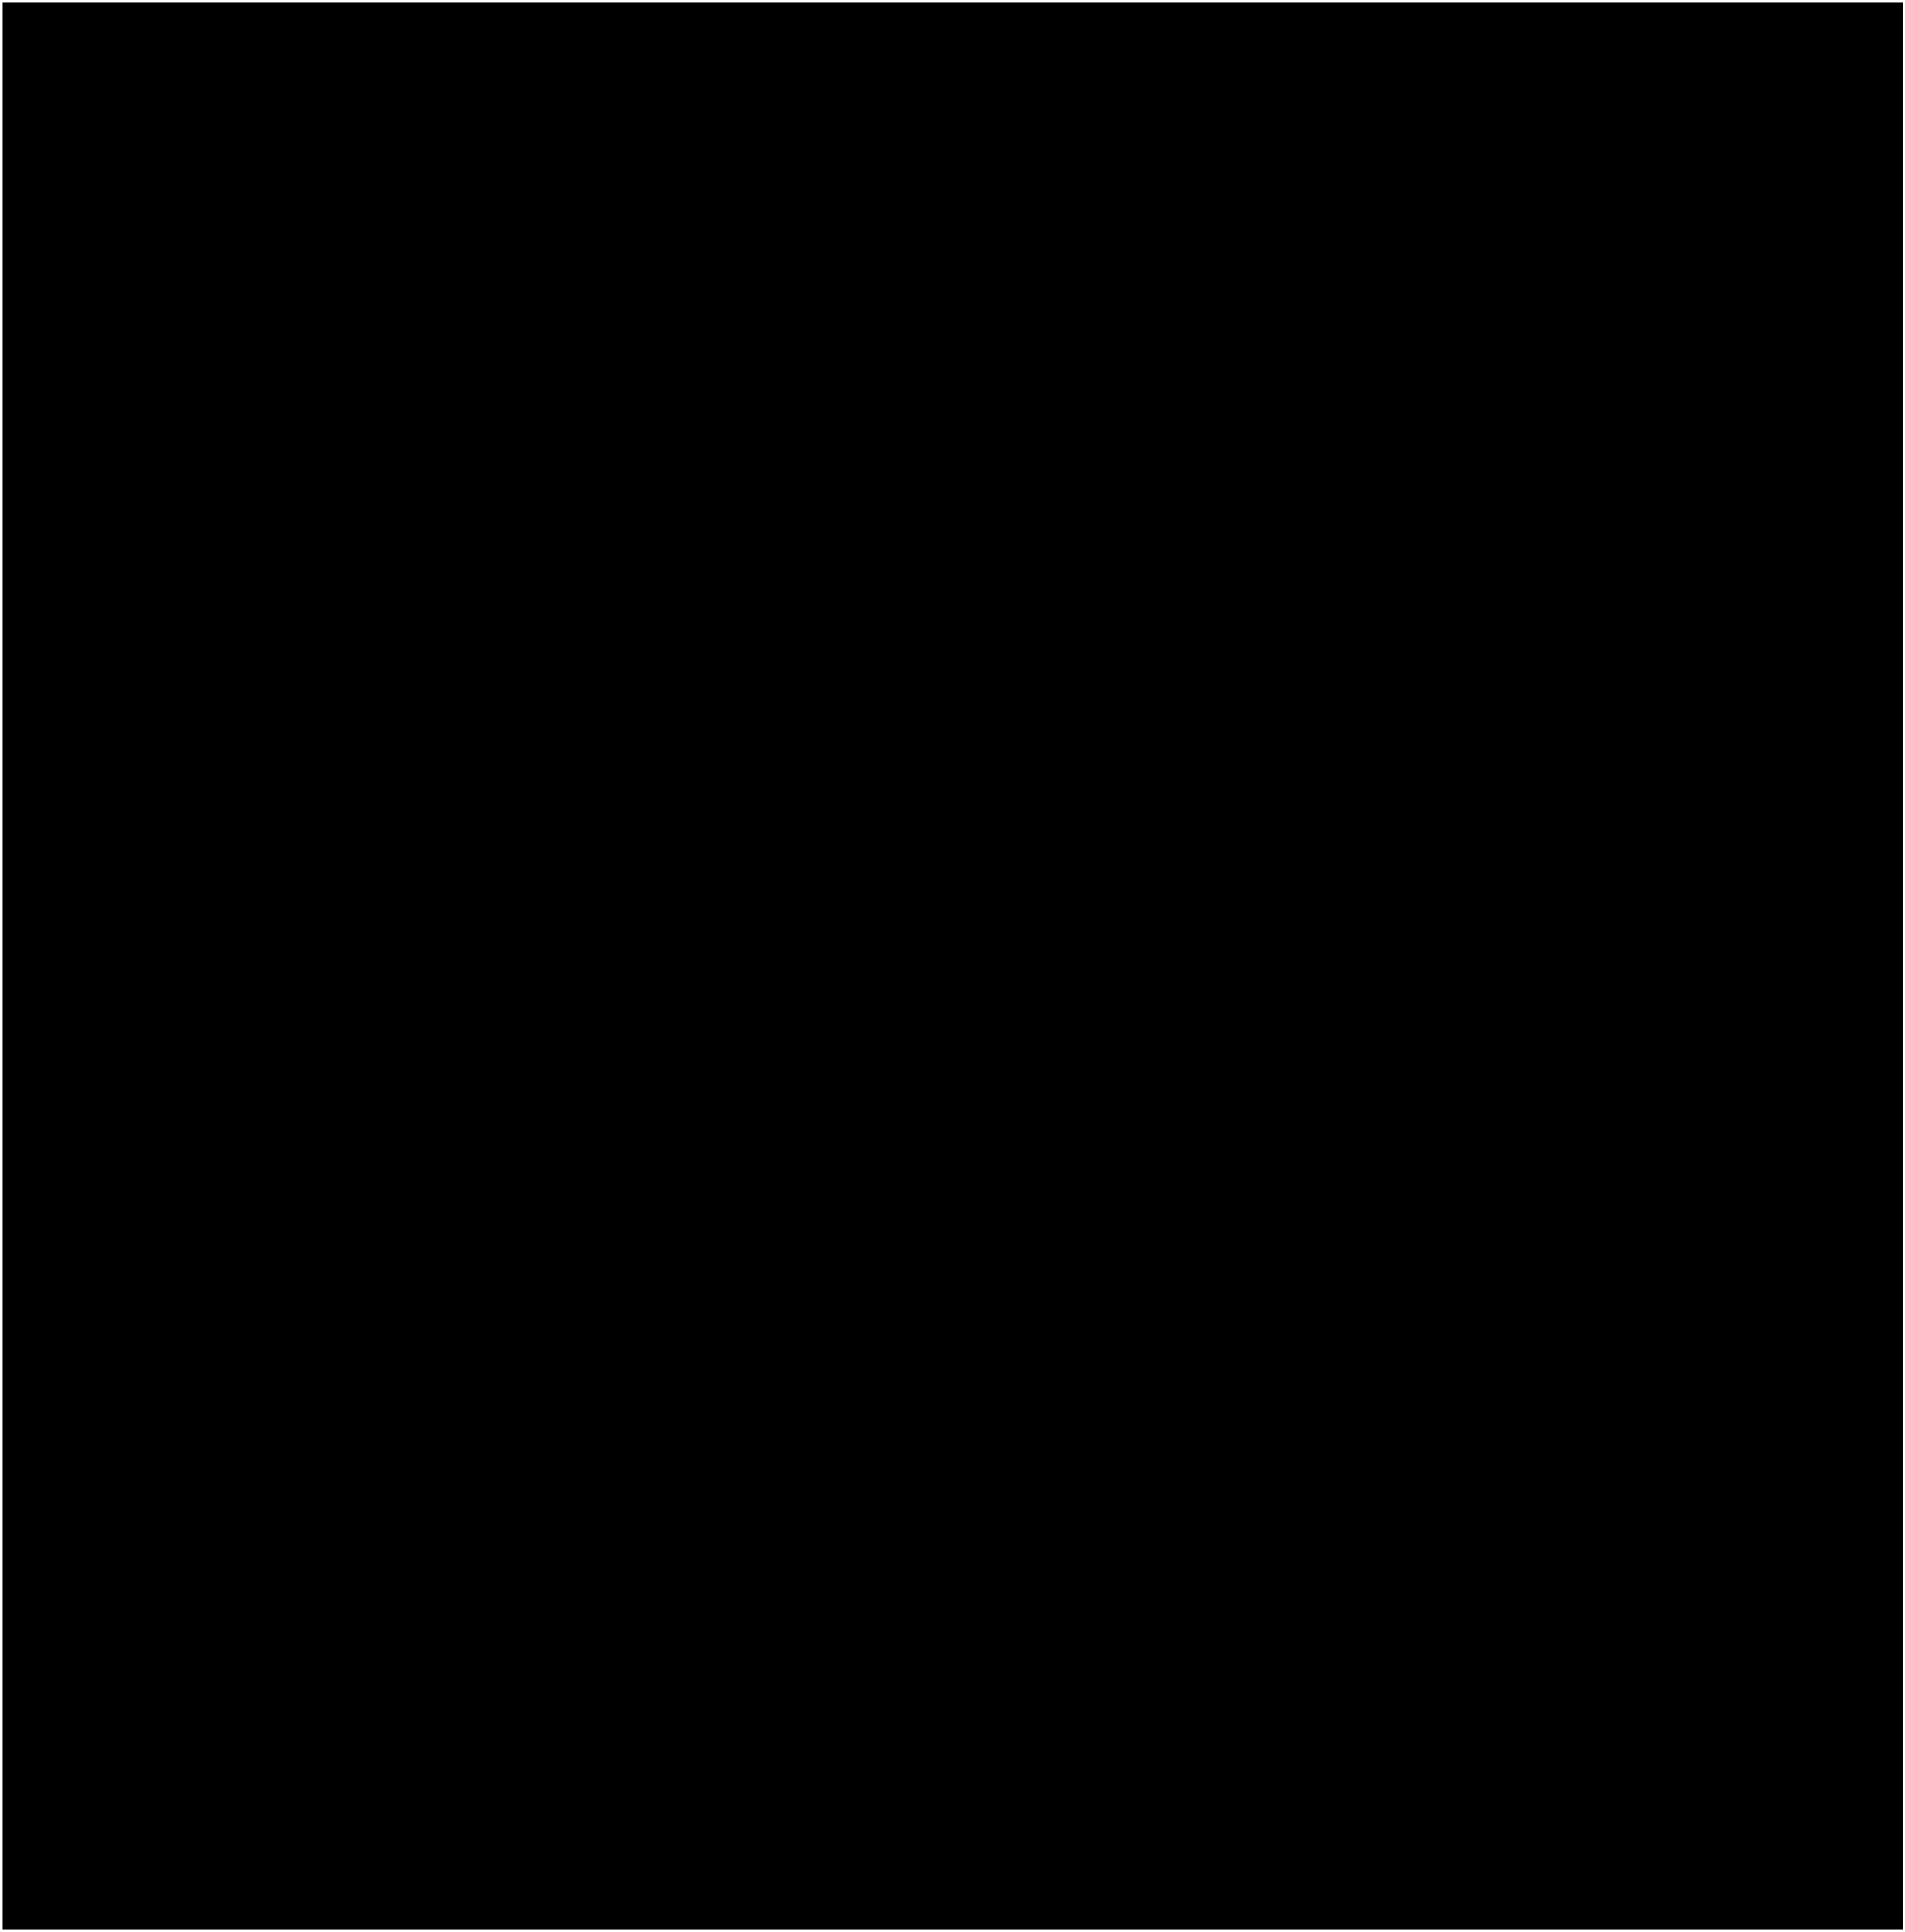

In [23]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(100, 100)) # figsize(20, 20)

for row in range(n_rows):
    for col in range(n_cols):
        axs[row][col].imshow(images[row * n_rows + col], cmap="gray")
        axs[row][col].axis("off")

plt.subplots_adjust(wspace=-0.3, hspace=0)

In [24]:
## UMAP ##
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(generated_data)
labels = np.array(labels).flatten()

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(n_classes):
    indices = np.where(labels==i)[0]
    plt.scatter(embedding[indices, 0], embedding[indices, 1], s=5, label=i, color=COLORS[i%10])
plt.title("{} Generated MNIST Data".format(model_name), fontsize=18)
plt.legend(markerscale=2)

NameError: name 'generated_data' is not defined